# Beer Image Processing
#### Using cv2 and tensorflow (DNN and LSTM) 

## IMPORTING

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## PREPROCESSING

In [2]:
def get_beer_color(image):
    # Resize the image
    cropped_image = image[94:118, 114:138] # 24 x 24
    
    # Calculate the average color (BGR format)
    avg_color = cv2.mean(cropped_image)[:3]
    
    avg_color_rgb = avg_color[::-1]

    return avg_color_rgb

In [3]:
def get_sediment_image(image):
    # Resize the image
    image = image[212:252, 114:158] # 48 x 40
    
    # Convert the image depth to CV_32F if necessary
    if image.dtype != np.float32:
        image = image.astype(np.float32)
    
    return image

In [4]:
def get_foam_image(image):
    # Resize the image
    image = image[14:96, 96:108] # 12 x 72
    
    # Convert the image depth to CV_32F if necessary
    if image.dtype != np.float32:
        image = image.astype(np.float32)
        
    return image

In [5]:
def normalize(image):
    # normalization for visualisation
    image_data_type = image.dtype

    if image_data_type == np.float32 or image_data_type == np.float64:
        # Normalize the float image to the range [0, 1]
        normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    else:
        # Convert the image to float and normalize it to the range [0, 1]
        normalized_image = image.astype(np.float32) / 255.0

    return normalized_image
    

In [6]:
def get_height(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Increase the brightness and contrast of the image
    image = cv2.convertScaleAbs(image, alpha=0.68, beta=14)

    # Convert the grayscale image back to RGB
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Convert the HSV image to grayscale
    gray = cv2.cvtColor(hsv, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create the mask
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Initialize min and max height variables
    min_height = None
    max_height = None

    # Iterate through the mask to find the highest and lowest points with continuous color
    for y in range(mask.shape[0]):
        # Check if the current row contains continuous color
        if np.all(mask[y, :] > 0):
            if min_height is None:
                min_height = y
            max_height = y

    # Calculate the height
    if min_height is not None and max_height is not None:
        height = max_height - min_height + 1
    else:
        height = 0

    return height


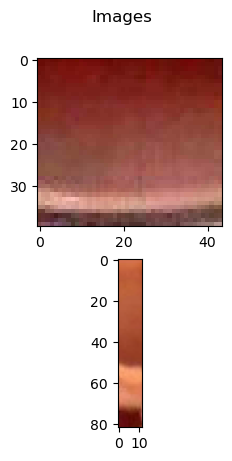

In [7]:
import glob
import os

# Get all .jpg image paths in a folder
folder_path = "../PythonArduino/PythonCode/images/"
image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))

# Sort image paths based on their names (assuming they are named with ascending timestamps)
image_paths.sort()

# Set corresponding timestamps for each image
timestamps = list(range(len(image_paths)))  # Using indices as timestamps, you can replace them with actual timestamps if available

fig, axs = plt.subplots(2)
fig.suptitle('Images')

data = []
for image_path, timestamp in zip(image_paths, timestamps):
      
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image
    image = image[224:480, 244:500] # 256 x 256
    
    # sediment
    sediment_image = get_sediment_image(image)
    sediment_image = normalize(sediment_image)
    axs[0].imshow(cv2.cvtColor(sediment_image, cv2.COLOR_BGR2RGB))
    sediment_height= get_height(sediment_image)
    
    # foam
    foam_image = get_foam_image(image)
    foam_image = normalize(foam_image)
    axs[1].imshow(cv2.cvtColor(foam_image, cv2.COLOR_BGR2RGB))
    foam_height= get_height(foam_image)
    
    # beer color
    beer_color = get_beer_color(image)
    
    data.append([timestamp, foam_height, beer_color, sediment_height])

# Convert data to a DataFrame
df = pd.DataFrame(data, columns=["timestamp", "foam_height", "beer_color", "sediment_height"])


In [8]:
def rgb_to_gray(rgb_tuple):
    R, G, B = rgb_tuple
    return 0.2989 * R + 0.5870 * G + 0.1140 * B

# Convert the beer_color column to grayscale
df["beer_color"] = df["beer_color"].apply(rgb_to_gray)

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Add fermentation progress to the DataFrame
fermentation_progress = [] # List of fermentation progress values corresponding to each image
for i in range(len(image_paths)):
    fermentation_progress.append(round((100 / (len(image_paths) - 1)) * i, 2))

df["fermentation_progress"] = fermentation_progress

In [10]:
df

,timestamp,foam_height,beer_color,sediment_height,fermentation_progress
0,0,82,44.471429,40,0.00
1,1,82,49.268021,40,0.15
2,2,82,52.345493,40,0.30
3,3,82,54.596969,40,0.45
4,4,82,55.655010,40,0.59
...,...,...,...,...,...
670,670,82,46.163481,40,99.41
671,671,82,46.024424,40,99.55
672,672,82,45.801462,40,99.70
673,673,82,45.736491,40,99.85


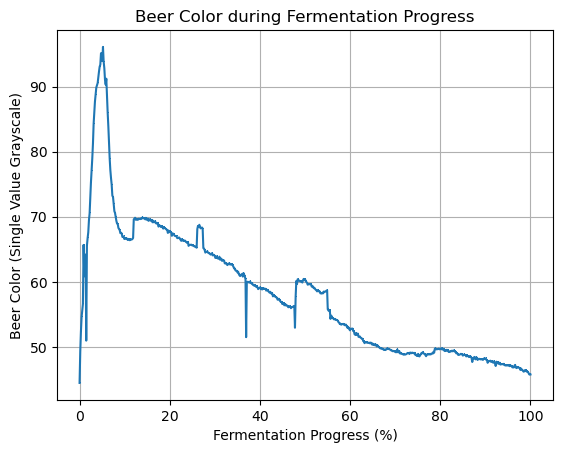

In [18]:
plt.plot(df['fermentation_progress'], df['beer_color'], marker=',', linestyle='-')
plt.xlabel('Fermentation Progress (%)')
plt.ylabel('Beer Color (Single Value Grayscale)')
plt.title('Beer Color during Fermentation Progress')
plt.grid()
plt.show()

In [12]:
# Define input and output columns
input_columns = ["foam_height", "beer_color", "sediment_height"]
output_column = "fermentation_progress"

# Normalize the input features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df[input_columns])

# Prepare the output values
y = df[output_column].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape the input data for LSTM (samples, timesteps, features)
timesteps = 1
X_train = X_train.reshape(X_train.shape[0], timesteps, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], timesteps, X_test.shape[1])

In [13]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss="mse", metrics=["mae"])

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/300


C:\Users\mark9\.conda\envs\ML-ENV\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


14/14 [==============================] - 3s 65ms/step - loss: 1363.2891 - mae: 31.9514 - val_loss: 5203.2041 - val_mae: 71.9848
Epoch 2/300
14/14 [==============================] - 0s 4ms/step - loss: 1359.3126 - mae: 31.8859 - val_loss: 5193.9082 - val_mae: 71.9202
Epoch 3/300
14/14 [==============================] - 0s 4ms/step - loss: 1353.4224 - mae: 31.7889 - val_loss: 5179.1416 - val_mae: 71.8174
Epoch 4/300
14/14 [==============================] - 0s 3ms/step - loss: 1343.4224 - mae: 31.6203 - val_loss: 5154.5654 - val_mae: 71.6460
Epoch 5/300
14/14 [==============================] - 0s 4ms/step - loss: 1326.7930 - mae: 31.3429 - val_loss: 5113.8057 - val_mae: 71.3608
Epoch 6/300
14/14 [==============================] - 0s 4ms/step - loss: 1299.5095 - mae: 30.8814 - val_loss: 5047.4087 - val_mae: 70.8938
Epoch 7/300
14/14 [==============================] - 0s 4ms/step - loss: 1255.9963 - mae: 30.1342 - val_loss: 4944.7007 - val_mae: 70.1653
Epoch 8/300
14/14 [===================

14/14 [==============================] - 0s 3ms/step - loss: 386.2029 - mae: 16.7547 - val_loss: 2122.0723 - val_mae: 45.8324
Epoch 61/300
14/14 [==============================] - 0s 4ms/step - loss: 376.8729 - mae: 16.5769 - val_loss: 2107.5298 - val_mae: 45.6735
Epoch 62/300
14/14 [==============================] - 0s 3ms/step - loss: 377.2390 - mae: 16.5669 - val_loss: 2091.8252 - val_mae: 45.5013
Epoch 63/300
14/14 [==============================] - 0s 3ms/step - loss: 375.9916 - mae: 16.5181 - val_loss: 2076.9685 - val_mae: 45.3377
Epoch 64/300
14/14 [==============================] - 0s 3ms/step - loss: 374.9994 - mae: 16.4301 - val_loss: 2061.2734 - val_mae: 45.1643
Epoch 65/300
14/14 [==============================] - 0s 4ms/step - loss: 368.2448 - mae: 16.4929 - val_loss: 2048.4553 - val_mae: 45.0222
Epoch 66/300
14/14 [==============================] - 0s 4ms/step - loss: 367.6992 - mae: 16.3445 - val_loss: 2034.8016 - val_mae: 44.8703
Epoch 67/300
14/14 [====================

Epoch 119/300
14/14 [==============================] - 0s 3ms/step - loss: 352.1770 - mae: 16.2000 - val_loss: 1689.5022 - val_mae: 40.8421
Epoch 120/300
14/14 [==============================] - 0s 3ms/step - loss: 351.0410 - mae: 16.1577 - val_loss: 1685.1775 - val_mae: 40.7892
Epoch 121/300
14/14 [==============================] - 0s 3ms/step - loss: 341.5339 - mae: 15.9317 - val_loss: 1683.1327 - val_mae: 40.7641
Epoch 122/300
14/14 [==============================] - 0s 3ms/step - loss: 354.2159 - mae: 16.1905 - val_loss: 1682.5334 - val_mae: 40.7567
Epoch 123/300
14/14 [==============================] - 0s 3ms/step - loss: 339.4208 - mae: 15.9293 - val_loss: 1681.0601 - val_mae: 40.7387
Epoch 124/300
14/14 [==============================] - 0s 3ms/step - loss: 360.2609 - mae: 16.4078 - val_loss: 1677.1436 - val_mae: 40.6906
Epoch 125/300
14/14 [==============================] - 0s 3ms/step - loss: 351.3663 - mae: 16.1682 - val_loss: 1675.8174 - val_mae: 40.6743
Epoch 126/300
14/14 

14/14 [==============================] - 0s 3ms/step - loss: 347.8891 - mae: 16.0771 - val_loss: 1653.4132 - val_mae: 40.3981
Epoch 178/300
14/14 [==============================] - 0s 4ms/step - loss: 342.3959 - mae: 15.9845 - val_loss: 1651.9647 - val_mae: 40.3801
Epoch 179/300
14/14 [==============================] - 0s 4ms/step - loss: 357.7311 - mae: 16.2590 - val_loss: 1650.4541 - val_mae: 40.3614
Epoch 180/300
14/14 [==============================] - 0s 4ms/step - loss: 350.9998 - mae: 16.0863 - val_loss: 1651.7758 - val_mae: 40.3778
Epoch 181/300
14/14 [==============================] - 0s 3ms/step - loss: 352.8417 - mae: 16.2996 - val_loss: 1654.0667 - val_mae: 40.4062
Epoch 182/300
14/14 [==============================] - 0s 3ms/step - loss: 349.6000 - mae: 16.0944 - val_loss: 1652.0190 - val_mae: 40.3808
Epoch 183/300
14/14 [==============================] - 0s 3ms/step - loss: 341.2524 - mae: 15.9633 - val_loss: 1653.0588 - val_mae: 40.3937
Epoch 184/300
14/14 [=============

14/14 [==============================] - 0s 4ms/step - loss: 356.5725 - mae: 16.3305 - val_loss: 1633.7711 - val_mae: 40.1543
Epoch 236/300
14/14 [==============================] - 0s 4ms/step - loss: 353.6518 - mae: 16.1369 - val_loss: 1635.0010 - val_mae: 40.1696
Epoch 237/300
14/14 [==============================] - 0s 4ms/step - loss: 350.7296 - mae: 16.1892 - val_loss: 1638.5186 - val_mae: 40.2134
Epoch 238/300
14/14 [==============================] - 0s 4ms/step - loss: 350.7096 - mae: 16.1664 - val_loss: 1639.8309 - val_mae: 40.2297
Epoch 239/300
14/14 [==============================] - 0s 5ms/step - loss: 347.9005 - mae: 16.1170 - val_loss: 1641.3486 - val_mae: 40.2486
Epoch 240/300
14/14 [==============================] - 0s 3ms/step - loss: 339.0966 - mae: 15.9180 - val_loss: 1639.4985 - val_mae: 40.2256
Epoch 241/300
14/14 [==============================] - 0s 3ms/step - loss: 348.9982 - mae: 16.0688 - val_loss: 1641.8881 - val_mae: 40.2553
Epoch 242/300
14/14 [=============

14/14 [==============================] - 0s 3ms/step - loss: 350.7874 - mae: 16.1994 - val_loss: 1648.0132 - val_mae: 40.3313
Epoch 294/300
14/14 [==============================] - 0s 3ms/step - loss: 351.5379 - mae: 16.2841 - val_loss: 1644.7939 - val_mae: 40.2914
Epoch 295/300
14/14 [==============================] - 0s 3ms/step - loss: 349.1000 - mae: 16.0973 - val_loss: 1645.3488 - val_mae: 40.2982
Epoch 296/300
14/14 [==============================] - 0s 3ms/step - loss: 354.0569 - mae: 16.2388 - val_loss: 1643.1313 - val_mae: 40.2707
Epoch 297/300
14/14 [==============================] - 0s 3ms/step - loss: 344.5289 - mae: 15.9962 - val_loss: 1644.7238 - val_mae: 40.2905
Epoch 298/300
14/14 [==============================] - 0s 3ms/step - loss: 356.2987 - mae: 16.2800 - val_loss: 1647.0435 - val_mae: 40.3193
Epoch 299/300
14/14 [==============================] - 0s 3ms/step - loss: 349.6941 - mae: 16.0869 - val_loss: 1647.3560 - val_mae: 40.3231
Epoch 300/300
14/14 [=============

5/5 [==============================] - 0s 1ms/step - loss: 3438.8721 - mae: 58.3560
Test loss: 3438.8720703125, Test MAE: 58.35600280761719


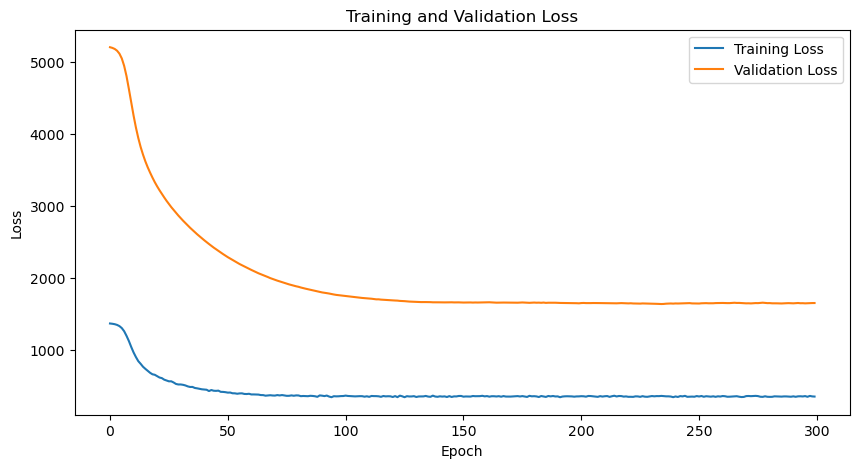

In [14]:
# Evaluate the model on the testing dataset
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {test_loss}, Test MAE: {test_mae}")

# Visualize the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()